<a href="https://colab.research.google.com/github/constructor-s/aps1080_winter_2021/blob/main/E3/E3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# Exercise III: Cart-Pole with TD(0)

    Due Monday by 11:59pm Points 100 Submitting a file upload File Types pdf

> Solve the Cart-Pole control problem using TD(0) methods.
> 
> For control use
> 
> a. on-policy SARSA
> 
> b. off-policy Q learning
> 
> c. off-policy Expected SARSA with an epsilon-greedy policy
> 
>  
> 
> This is to prepare you for the next assignment which will be a slight extension of TD(0).

In [17]:
#%% Boilerplate setup

import gym, numpy as np, matplotlib.pyplot as plt

# Discretization of states

"""
Observation:
    Type: Box(4)
    Num     Observation               Min                     Max
    0       Cart Position             -4.8                    4.8
    1       Cart Velocity             -Inf                    Inf
    2       Pole Angle                -0.418 rad (-24 deg)    0.418 rad (24 deg)
    3       Pole Angular Velocity     -Inf                    Inf
The episode ends when the pole is more than 15 degrees from vertical, 
or the cart moves more than 2.4 units from the center.
15 degree is 0.262 rad
"""

def obs2state(obs):
    """
    Discretize observations to states
    """
    digitized = [np.searchsorted(bins, o, "right") 
            for o, bins in zip(obs, obs2state.bin_divide)]
    return (digitized * obs2state.multiplier).sum()
obs2state.bin_divide = (
        (-2.30, +0.00, +2.30),
        (-1.00, +0.00, +1.00),
        (-0.20, +0.00, +0.20),
        (-1.00, +0.00, +1.00),
        )
obs2state.multiplier = np.concatenate([
                [1], 
                np.cumprod([len(i)+1 for i in obs2state.bin_divide[:-1]])
])
obs2state.S = np.product([len(i)+1 for i in obs2state.bin_divide])

def test_cart_pole(policy_fun, env=gym.make("CartPole-v0"), 
                   max_iter=1000, debug=False):
    """
    Test the policy against the environment

    Parameters
    ------------------
    policy_fun : function
        A funtion that takes the discretized state from the CartPole 
        environment and returns a valid action of the environment

    Yields
    ------
    S_t, A_t, R_t+1, S_t+1, A_t+1, done
        SARSA pairs. S is the discretized state
    """
    obs = env.reset(); s = obs2state(obs)
    a = policy_fun(s)
    for i in range(max_iter):
        next_obs, r, done, info = env.step(a); next_s = obs2state(next_obs)
        next_a = policy_fun(next_s)
        yield s, a, r, next_s, next_a, done
        if debug and i<199 and done:
            print(obs)
        obs, s, a = next_obs, next_s, next_a
        if done:
            if debug and i<199:
                print(obs)
            break
    env.close()

# Test that the function works
rng = np.random.RandomState(0)
print("\n".join(map(str, enumerate(test_cart_pole(lambda _: rng.randint(0, 2))))))

(0, (101, 0, 1.0, 165, 1, False))
(1, (165, 1, 1.0, 101, 1, False))
(2, (101, 1, 1.0, 105, 0, False))
(3, (105, 0, 1.0, 101, 1, False))
(4, (101, 1, 1.0, 105, 1, False))
(5, (105, 1, 1.0, 89, 1, False))
(6, (89, 1, 1.0, 89, 1, False))
(7, (89, 1, 1.0, 25, 1, False))
(8, (25, 1, 1.0, 26, 1, False))
(9, (26, 1, 1.0, 30, 1, False))
(10, (30, 1, 1.0, 30, 0, False))
(11, (30, 0, 1.0, 30, 0, False))
(12, (30, 0, 1.0, 10, 1, False))
(13, (10, 1, 1.0, 14, 0, True))


## On-policy SARSA

### Training

In [18]:
#%% on-policy SARSA
# page 130

from IPython.display import clear_output
import pandas as pd

def train(update_fun,    
        alpha = 0.5,
        eps = 0.001,
        gamma = 0.9,
        num_S = obs2state.S,
        num_A = 2,
        seed = 0):
    """
    Generic template for training of Temporal-Difference (TD) methods

    Parameters:
    ----------------
    update_fun : function
        Function with inputs: Q, s, a, r, s_, a_, done, alpha, gamma
        Function should modify Q in place for update

    Returns:
    ----------------
    locals() : 
        All local variables
    """
    rng = np.random.RandomState(seed)
    Q = rng.random([num_S, num_A]); assert (Q > 0).all()

    training_hist = []
    testing_hist = []
    try:
        for episode_i in range(10000):
            policy_fun = lambda s: rng.choice(
                (np.argmax(Q[s]), rng.randint(num_A)), 
                p=(1-eps, eps))
            for step_i, (s, a, r, s_, a_, done) in enumerate(
                                                test_cart_pole(policy_fun)):
                # Q[s, a] = Q[s, a] + alpha * (
                #                         r + gamma * Q[s_, a_] * (1-done) - Q[s, a])
                update_fun(Q, s, a, r, s_, a_, done, alpha, gamma)
            training_hist.append((episode_i, step_i))
            if episode_i % 500 == 0:
                testing_hist.append((
                    episode_i, len(list(test_cart_pole(lambda s: np.argmax(Q[s]))))
                ))
                clear_output(wait=True)
                training_hist_ = np.array(training_hist)
                testing_hist_ = np.array(testing_hist)
                plt.scatter(training_hist_[:, 0], training_hist_[:, 1], s=0.1, alpha=0.5)
                plt.plot(training_hist_[:, 0], pd.Series(training_hist_[:, 1]).rolling(100).median())
                plt.plot(testing_hist_[:, 0], testing_hist_[:, 1], 'x')
                plt.xlabel("Training episode")
                plt.ylabel("Performance (steps)")
                plt.title("Training/Testing performance")
                plt.grid()
                plt.show()
                print(f"Training: Episode {episode_i} lasted {step_i} steps")
    except KeyboardInterrupt as e:
        print(e)
    finally:
        clear_output(wait=True)
        training_hist_ = np.array(training_hist)
        testing_hist_ = np.array(testing_hist)
        plt.scatter(training_hist_[:, 0], training_hist_[:, 1], s=0.1, alpha=0.5)
        plt.plot(training_hist_[:, 0], pd.Series(training_hist_[:, 1]).rolling(100).median())
        plt.plot(testing_hist_[:, 0], testing_hist_[:, 1], 'x')
        plt.xlabel("Training episode")
        plt.ylabel("Performance (steps)")
        plt.title("Training/Testing performance")
        plt.grid()
        plt.show()
        return locals()


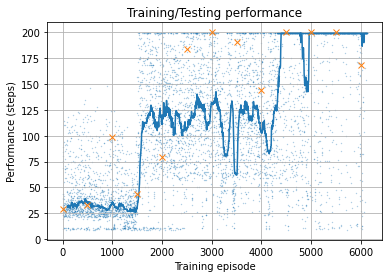

In [ ]:
def sarsa_update_fun(Q, s, a, r, s_, a_, done, alpha, gamma, *args, **kwargs):
    Q[s, a] = Q[s, a] + alpha * (r + gamma * Q[s_, a_] * (1-done) - Q[s, a])

globals().update(train(update_fun=sarsa_update_fun, alpha=0.1, eps=0.005))

### Testing

In [ ]:
for episode_i in range(10):
    policy_fun = lambda s: np.argmax(Q[s])
    for step_i, (s, a, r, s_, a_, done) in enumerate(test_cart_pole(policy_fun)):
        pass
    print(f"Testing: Episode {episode_i} lasted {step_i} steps")

Testing: Episode 0 lasted 199 steps
Testing: Episode 1 lasted 199 steps
Testing: Episode 2 lasted 199 steps
Testing: Episode 3 lasted 199 steps
Testing: Episode 4 lasted 199 steps
Testing: Episode 5 lasted 199 steps
Testing: Episode 6 lasted 199 steps
Testing: Episode 7 lasted 199 steps
Testing: Episode 8 lasted 199 steps
Testing: Episode 9 lasted 194 steps


## Off-policy Q learning

### Training

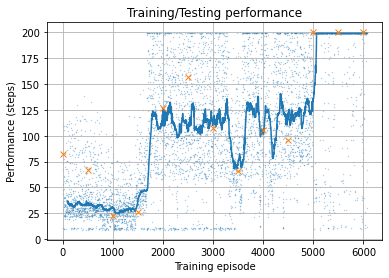

In [ ]:
#%% Q-learning
# page 131

def qlearning_update_fun(Q, s, a, r, s_, a_, done, alpha, gamma, *args, **kwargs):
    Q[s, a] = Q[s, a] + alpha * (r + gamma * np.max(Q[s_]) * (1-done) - Q[s, a])

globals().update(train(update_fun=qlearning_update_fun, alpha=0.1, eps=0.005))


### Testing

In [ ]:
for episode_i in range(10):
    policy_fun = lambda s: np.argmax(Q[s])
    for step_i, (s, a, r, s_, a_, done) in enumerate(test_cart_pole(policy_fun)):
        pass
    print(f"Testing: Episode {episode_i} lasted {step_i} steps")

Testing: Episode 0 lasted 199 steps
Testing: Episode 1 lasted 199 steps
Testing: Episode 2 lasted 199 steps
Testing: Episode 3 lasted 199 steps
Testing: Episode 4 lasted 199 steps
Testing: Episode 5 lasted 199 steps
Testing: Episode 6 lasted 199 steps
Testing: Episode 7 lasted 199 steps
Testing: Episode 8 lasted 199 steps
Testing: Episode 9 lasted 199 steps


## Off-policy Expected SARSA with an epsilon-greedy policy

### Training

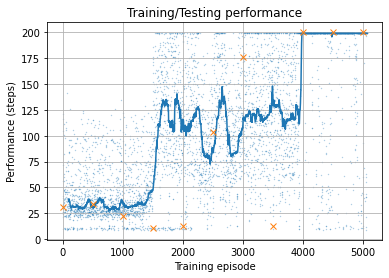

In [21]:
#%% Expected SARSA
# page 133
# 
# As stated on the textbook page 134
# "For example, suppose pi is the greedy policy while
# behavior is more exploratory; 
# then Expected Sarsa is exactly Q-learning."
# Therefore, since we are using the greedy policy here
# Expected SARSA is exactly the same as Q-learning

def eSARSA_update_fun(Q, s, a, r, s_, a_, done, alpha, gamma, *args, **kwargs):
    p = np.zeros(Q.shape[1]); p[np.argmax(Q[s_])] = 1.0
    Q[s, a] = Q[s, a] + alpha * (r + gamma * (Q[s_] @ p) * (1-done) - Q[s, a])

globals().update(train(update_fun=qlearning_update_fun, alpha=0.1, eps=0.005))


### Testing

In [22]:
for episode_i in range(10):
    policy_fun = lambda s: np.argmax(Q[s])
    for step_i, (s, a, r, s_, a_, done) in enumerate(test_cart_pole(policy_fun, debug=True)):
        pass
    print(f"Testing: Episode {episode_i} lasted {step_i} steps")

Testing: Episode 0 lasted 199 steps
Testing: Episode 1 lasted 199 steps
Testing: Episode 2 lasted 199 steps
Testing: Episode 3 lasted 199 steps
Testing: Episode 4 lasted 199 steps
Testing: Episode 5 lasted 199 steps
Testing: Episode 6 lasted 199 steps
Testing: Episode 7 lasted 199 steps
Testing: Episode 8 lasted 199 steps
Testing: Episode 9 lasted 199 steps
